In [216]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

### Import the dataframe containing tweets

In [2]:
df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)
df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0


#### Investigate basic components of the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          8936 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object 
 3   brand                                               3282 non-null   object 
 4   tweet_clean                                         8936 non-null   object 
 5   target                                              8936 non-null   float64
dtypes: float64(1), object(5)
memory usage: 488.7+ KB


In [4]:
df.target.value_counts(normalize=True)

0.0    0.602954
2.0    0.333259
1.0    0.063787
Name: target, dtype: float64

In [5]:
for i in df.columns:
    print(i)

tweet_text
emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product
brand
tweet_clean
target


In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

## Emotion Value Breakdown

- No emotion       | 60.3%
- Positive emotion | 33.3%
- Negative emotion | 6.4%

This verges on perhaps being too imbalanced of a distribution and may require some sort of class weighting or synthetic resampling as we iterate through models. 

## Brand Breakdown

In [7]:
df.brand.isna().sum()

5654

#### Brands associated with the tweets

In [8]:
df.brand.fillna(value="missing").value_counts(normalize=True)

missing    0.632722
Apple      0.268800
Google     0.098478
Name: brand, dtype: float64

While knowing the brand names is not directly essential for our project, we may want to train a separate model to fill the nans with brand predictions from our model. It could at least be a fun exercise.

# Problem Description

Our task is to identify whether or not tweets have positive or negative emotions. From the assignment:

"There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix."

# Creating a binary dataframe:

In [9]:
binary_df = df.loc[df.target != 0].copy()

In [10]:
df.shape[0] - df.loc[df.target == 0].shape[0]

3548

### Binary values of positive or negative only

In [11]:
binary_df.shape

(3548, 6)

In [12]:
binary_df.target.value_counts(normalize=True)

2.0    0.839346
1.0    0.160654
Name: target, dtype: float64

We have a ratio of more or less 5 - to - 1 Positive to negative. I will re-map the values of the target column so that "0" is a positive review, and "1" is a negative review.

### Modifying the column

In [13]:
binary_df['target'] = binary_df['target'].apply(lambda x: 0 if x == 2 else x)

#### Sanity Check

In [14]:
binary_df['target'].value_counts()

0.0    2978
1.0     570
Name: target, dtype: int64

### Preprocessing

Now that a binary column of 0's and 1's is in place, I will begin the process of preparing the tweets as tokens with the correct lemmatization, case, and removal of stop words. 

#### Re-examination of the df

In [15]:
binary_df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,0.0


### Creating a function to handle all of the preprocessing tasks, borrowing from lecture material

In [16]:
### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


### This is the function that will be applied to the dataframe

In [17]:
def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc
    

# Defining a class to track the model iterations

### Initially created for multi-class classification

In [180]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = vectorizer.fit_transform(X_train)
        self.X_test = vectorizer.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [18]:
binary_df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product', 'brand',
       'tweet_clean', 'target'],
      dtype='object')

### Converting the original tweets into a new column

In [19]:
binary_df['tokens'] = binary_df['tweet_text'].apply(preprocess)

### Examination of how the tweets have been converted

In [20]:
binary_df['tokens'][0]

'wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw'

In [21]:
binary_df['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [22]:
# 1 is a negative experience
binary_df['target'][0]

1.0

# Vectorization of the data

In previous exercises, we have used the raw, un-edited text to represent our X variable and the label to represent our y variable. In this case, that would make "binary_df['tweet_text']" our X, and "binary_df['target']" our y. I am inclined to use the joined string of tokens as our X variable, and the labels as our y.

In [23]:
# Assign the proper values to our X and y variables
X = binary_df['tokens']
y = binary_df['target']

In [24]:
# Train test split on the data, stratifying because of the relative imbalance of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Vectorizers: Count Vectorizer | TF-IDF Vectorizer

In [25]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer()
Xt_tfidf = tfidf.fit_transform(X_train)

### Visual Inspection of the TF-IDF data

In [27]:
# Cell takes a couple minutes to run
df_tfidf = pd.DataFrame(Xt_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf.head(2)

aapl  abacus  abandon  aber  ability  able  abroad  absolute  absolutely  \
0   0.0     0.0      0.0   0.0      0.0   0.0     0.0       0.0         0.0   
1   0.0     0.0      0.0   0.0      0.0   0.0     0.0       0.0         0.0   

   abt  abuzz  academy  acc  acceptable  access  accessibility  accessible  \
0  0.0    0.0      0.0  0.0         0.0     0.0            0.0         0.0   
1  0.0    0.0      0.0  0.0         0.0     0.0            0.0         0.0   

   accessory  accesssxsw  accord  accordion  account  achieve  acknowledge  \
0        0.0         0.0     0.0        0.0      0.0      0.0          0.0   
1        0.0         0.0     0.0        0.0      0.0      0.0          0.0   

   aclu  acquire  across  acrosse  action  activate  activation  actual  \
0   0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0   
1   0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0   

   actually   ad  adam  adapt  adaptive  add  addict  addictedtotheinterwebs  \
0       0.0  0.0   0.0    0.0       0.0  0.0     0.0                     0.0   
1       0.0  0.0   0.0    0.0       0.0  0.0     0.0                     0.0   

   addiction  addition  adfonic  admire  admission  admit  ado  adopter  \
0        0.0       0.0      0.0     0.0        0.0    0.0  0.0      0.0   
1        0.0       0.0      0.0     0.0        0.0    0.0  0.0      0.0   

   adoption  adpeopleproblems  advance  advantage  advent  adventure  \
0       0.0               0.0      0.0        0.0     0.0        0.0   
1       0.0               0.0      0.0        0.0     0.0        0.0   

   advertising  advice  advisory  affair  affirmative  afford  afraid  \
0          0.0     0.0       0.0     0.0          0.0     0.0     0.0   
1          0.0     0.0       0.0     0.0          0.0     0.0     0.0   

   african  afternoon  agchat  age  agency  agenda  agent  agileagency  \
0      0.0        0.0     0.0  0.0     0.0     0.0    0.0          0.0   
1      0.0        0.0     0.0  0.0     0.0     0.0    0.0          0.0   

   agnerd  ago  agree   ah  ahead  ahh  ahhh  ahing  aicn  aid  aim  ain  air  \
0     0.0  0.0    0.0  0.0    0.0  0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0    0.0  0.0    0.0  0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0   

   airline  airport  ajs  aka  akqas   al  ala  alamo  alan  alarm  album  \
0      0.0      0.0  0.0  0.0    0.0  0.0  0.0    0.0   0.0    0.0    0.0   
1      0.0      0.0  0.0  0.0    0.0  0.0  0.0    0.0   0.0    0.0    0.0   

   alert  alex  algorithm  alive  all  allhat  allow  almost  alone  along  \
0    0.0   0.0        0.0    0.0  0.0     0.0    0.0     0.0    0.0    0.0   
1    0.0   0.0        0.0    0.0  0.0     0.0    0.0     0.0    0.0    0.0   

   alot  alphagraphics  already  also  alt  alternate  alternative  although  \
0   0.0            0.0      0.0   0.0  0.0        0.0          0.0       0.0   
1   0.0            0.0      0.0   0.0  0.0        0.0          0.0       0.0   

   altimeter  always  alwayshavingtoplugin  amateurhour  amaze  amazing  \
0        0.0     0.0                   0.0          0.0    0.0      0.0   
1        0.0     0.0                   0.0          0.0    0.0      0.0   

   amazingly  amazon  ambassador  amble  amen  america  amex  amid  amigos  \
0        0.0     0.0         0.0    0.0   0.0      0.0   0.0   0.0     0.0   
1        0.0     0.0         0.0    0.0   0.0      0.0   0.0   0.0     0.0   

   amismarternow  among  amount  amp  amuse  analysis  analytics  andoid  \
0            0.0    0.0     0.0  0.0    0.0       0.0        0.0     0.0   
1            0.0    0.0     0.0  0.0    0.0       0.0        0.0     0.0   

   andrew  andriod  andro  android  androidsxsw  angel  angry  announce  \
0     0.0      0.0    0.0      0.0          0.0    0.0    0.0       0.0   
1     0.0      0.0    0.0      0.0          0.0    0.0    0.0       0.0   

   announcement  announces  annoy  another  answer  anti  anticipate  anti

In [34]:
X_train.iloc[0]

'rt mention join link start tonight person friends city end sxsw festival win ipad'

### General Sanity Check

In [51]:
df_tfidf.iloc[0].argmax()

1426

In [52]:
df_tfidf.iloc[0].argmax()

1426

In [50]:
df_tfidf.columns[1426]

'friends'

# First Dummy Model

In [182]:
dummy = DummyClassifier(strategy="most_frequent")

In [183]:
dummy.fit(Xt_tfidf, y_train)

DummyClassifier(strategy='most_frequent')

In [184]:
dummy.score(Xt_tfidf, y_train)

0.8391582111987974

In [58]:
y_train.value_counts(normalize=True)

0.0    0.839158
1.0    0.160842
Name: target, dtype: float64

By guessing the most frequent value, the dummy classifier correctly predicted the label 83.9% of the time, consistent with the distribution of labels in our training set. 

In [59]:
dummy.score(tfidf.transform(X_test), y_test)

0.8399098083427283

In [60]:
y_test.value_counts(normalize=True)

0.0    0.83991
1.0    0.16009
Name: target, dtype: float64

Again, the same is true for our test data. By choosing the class that occurs most frequently, our dummy classifier was correct at the exact frequency as the true distribution of our data. 

In [67]:
y_test.value_counts()

0.0    745
1.0    142
Name: target, dtype: int64

### Confusion Matrix: Dummy Model -> new method in new sklearn version

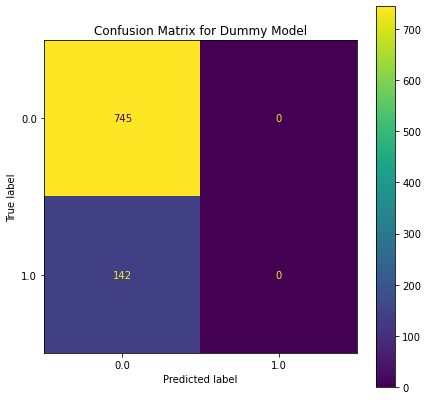

In [187]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(dummy, dummy.predict(tfidf.transform(X_test)), y_test, ax=ax)
ax.set_title("Confusion Matrix for Dummy Model");

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


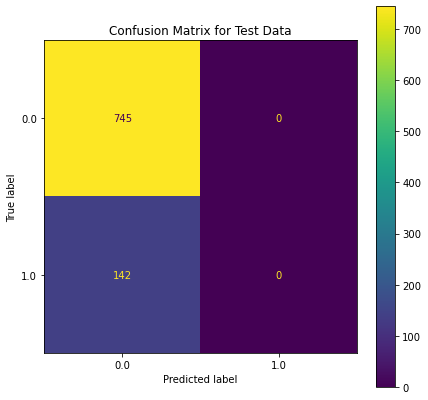

In [188]:
dummy_0 = Model("Dummy", dummy, tfidf, X_train, X_test, y_train, y_test)

In [189]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.0,0.0,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.5


### FSM Naive Bayes creation

In [190]:
mnb = MultinomialNB()

In [191]:
mnb.fit(Xt_tfidf, y_train)

MultinomialNB()

In [192]:
# Scores on training data
mnb.score(Xt_tfidf, y_train)

0.8575723412251034

In [193]:
# Test the predictions on test data
y_preds = mnb.predict(tfidf.transform(X_test))
accuracy_score(y_test, y_preds)

0.8455467869222097

In [194]:
cross_validate(mnb, Xt_tfidf, y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.00267768, 0.00324368, 0.00455403, 0.0036819 , 0.00400376]),
 'score_time': array([0.01127219, 0.01372004, 0.01534295, 0.01220918, 0.01186109]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.84615385, 0.84962406, 0.84398496, 0.84398496, 0.84586466]),
 'test_recall': array([0.04651163, 0.05882353, 0.02352941, 0.03488372, 0.04651163]),
 'test_f1': array([0.08888889, 0.11111111, 0.04597701, 0.06741573, 0.08888889]),
 'test_neg_log_loss': array([-0.38521923, -0.3714225 , -0.38615195, -0.38585453, -0.42158848])}

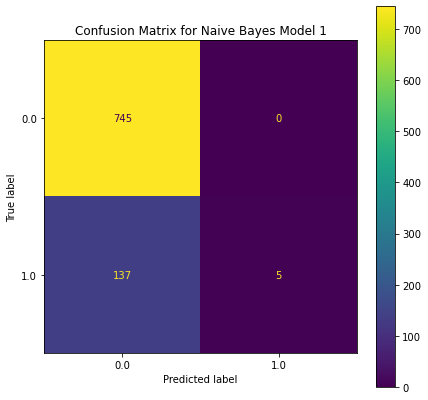

In [196]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(mnb, X=tfidf.transform(X_test), y=y_test, ax=ax)
ax.set_title("Confusion Matrix for Naive Bayes Model 1");

This baseline model exhibited a very slight improvement over our dummy classifier. The precision for class 1 is clearly too high to be useful. We will have to attempt to modify our model in order to improve the performance thereof.

In [200]:
pd.Series(mnb.predict(tfidf.transform(X_test))).value_counts(), "True Values:", "*" * 60, y_test.value_counts()

(0.0    882
 1.0      5
 dtype: int64,
 'True Values:',
 '************************************************************',
 0.0    745
 1.0    142
 Name: target, dtype: int64)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


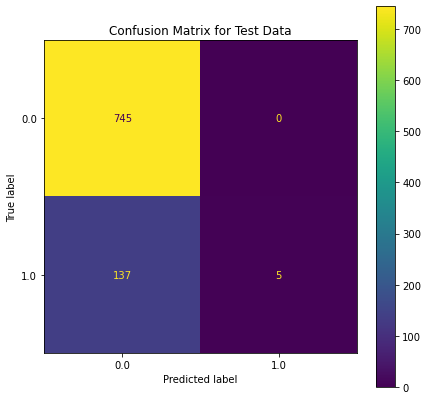

In [201]:
# I am receiving a warning about predictions not summing to 1, but everything seems to be working ok
mnb1 = Model("Naive Bayes 1", mnb, tfidf, X_train, X_test, y_train, y_test)

(0.7914358635031665, None)

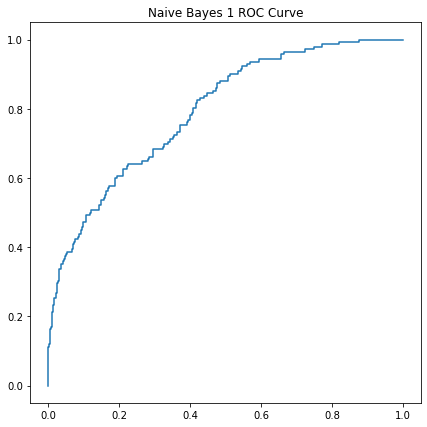

In [202]:
mnb1.auc, mnb1.roc_curve()

In [206]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.000000,0.000000,5.797319,0.839910,0.0,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.0,0.042052,0.080456,0.390047,0.845547,1.0,0.035211,0.068027,0.427074,0.791436


### Comparing the TF-IDF Vectorizer with a basic Count Vectorizer

In [ ]:
# Count Vectorizer
count_v = CountVectorizer()
Xt_count = count_v.fit_transform(X_train)

In [217]:
mnb_count = MultinomialNB()
mnb_count.fit(Xt_count, y_train)

MultinomialNB()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


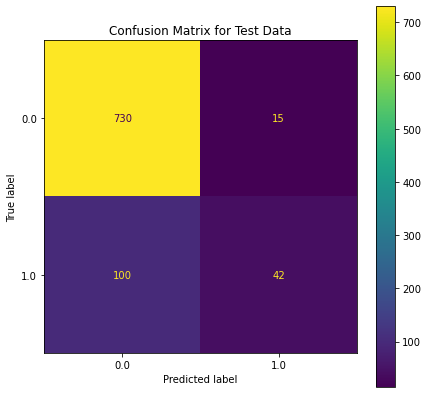

In [218]:
mnb_count1 = Model("MNB Count Vect", mnb_count, count_v, X_train, X_test, y_train, y_test)

In [219]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.000000,0.042052,0.080456,0.390047,0.845547,1.000000,0.035211,0.068027,0.427074,0.791436
2,MNB Count Vect,0.846297,0.534513,0.348181,0.420185,0.513858,0.870349,0.736842,0.295775,0.422111,0.555660,0.818650


In [228]:
# count_auc_plot = mnb_count1.roc_curve()
# tfidf_auc_plot = mnb1.roc_curve()

# fig, ax = plt.subplots(figsize=(7,7))
# ax.plot(count_auc_plot[0], count_auc_plot[1], color="red")
# ax.plot(tfidf_auc_plot[0], tfidf_auc_plot[1], color="blue")

Some ver

# Further Model Iteration Using Pipelines

In [ ]:
pipe